### Load Context

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

params = catalog.load('parameters')

data = catalog.load("data_proc")
vocab = catalog.load("vocabulary")

known_authors = params['known_authors']

2022-03-03 09:55:44,459 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
2022-03-03 09:55:44,459 - kedro.io.data_catalog - INFO - Loading data from `data_proc` (CSVDataSet)...
2022-03-03 09:55:44,612 - kedro.io.data_catalog - INFO - Loading data from `vocabulary` (CSVDataSet)...


In [2]:
params['model']

{'feat_reduction_method': 'none',
 'gamma': 0.15,
 'stbl': True,
 'measures': ['HC', 'Fisher']}

# Classification using ANOVA

We have corpora and documents we would like to test their attribution. For a corpus $\mathcal C$, define the corpus self-discrepancies as
$$
G_0(\mathcal C) := \{ d_{HC}(D',\mathcal C\setminus\{D'\})\}_{D' \in \mathcal C} 
$$

For a corpus $\mathcal C$ and a document $D$ not represented in $\mathcal C$, denote $\mathcal C(D) := \mathcal C \cup \{D\}$ (the corpus obtained by adding $D$ to $\mathcal C$). Define their set of combined discrepncies as
$$
G_1(D,\mathcal C) := \{d_{HC}(D',\mathcal C(D) \setminus \{D'\} )\}_{D' \in  \mathcal C^{(i)}}
$$

We compute two sum-of-squares:
$$
SS_0 = \sum_{x \in G_0(\mathcal C)} (x- \mathrm Avg\{G_0(\mathcal C)\} )^2
$$
$$
SS_1 = \sum_{x \in G_1(D,\mathcal C)} (x- \mathrm Avg\{G_1(D,\mathcal C)\} )^2
$$

Under some assumptions, it makes sense to use
$$
f = \frac{SS_1}{SS_0}
$$
and test against 
$$
H_0\,:\, f \sim F_{|\mathcal C|-1,|\mathcal C|-2}
$$


In [3]:
import numpy as np
from scipy.stats import f as fdist
from scipy.stats import t as tdist
from scipy.stats import norm
from scipy.stats import ttest_ind as ttest
from scipy.stats import levene
from scipy.stats import bartlett

def discrepancy(cnt1, cnt2, **kwargs):
    
    disc_type = kwargs.get('test', 'HC')
    gamma = kwargs.get('gamma', .2)
    
    pvals = bin_allocation_test(cnt1, cnt2)
    mt = MultiTest(pvals)
    if disc_type == 'HC':
        hc,_ = mt.hc_star(gamma = gamma)
        return hc
    if disc_type == 'Fisher':
        return np.mean(-np.log(pvals))
    
    raise ValueError("Only HC-discrepancy is supported")

def merge_list_of_dataframes(lo_df):
    dfr = pd.DataFrame()
    for df in lo_df:
        dfr = dfr.append(df, ignore_index=True)
    return dfr
        
class CompareDocsRelativeResponse(object):
    """
    Upon call, this object need to return 
    HC discrepancy of two points
    
    Can use CompareDocs model but does not have to
    The issue is how to decide on a vocabulary
    
    """
    def __init__(self, compare_docs_model, discrepancy_type='HC'):
        self.cd_model = compare_docs_model
        self.disc_type = discrepancy_type
    

    def __call__(self, X1, X2):
        cnt1 = self.cd_model.count_words(merge_list_of_dataframes(X1)).n
        cnt2 = self.cd_model.count_words(merge_list_of_dataframes(X2)).n
        return discrepancy(cnt1, cnt2, disc_type=self.disc_type)
    

def test_f(scores0, scores1):
    def _sum_of_squares(scores):
            return np.sum((scores - np.mean(scores)) ** 2)
        
    ss0 = _sum_of_squares(scores0)
    ss1 = _sum_of_squares(scores1)
    fstat = ss1 / ss0
    return fstat, fdist.sf(ss1 / ss0, dfn=len(scores1)-1,dfd=len(scores0)-1)


def test_bartlett(scores0, scores1):
    return bartlett(scores0, scores1)


def test_t_2smp(scores0, scores1):
    return ttest(scores0, scores1)

def test_t(scores0, scores1):
    mu = np.mean(scores1[:-1])
    t = (scores1[-1] - mu) / np.std(scores1[:-1])
    return t, tdist.sf(t, df=len(scores1) - 2) # one-sided


def test_linear(scores0, scores1):
    mu = np.mean(scores0)
    t = (scores1[-1] - mu) / np.std(scores0)
    return t, tdist.sf(t, df=len(scores0) - 1) # one-sided


def test_levene(scores0, scores1):
    return levene(scores0, scores1)

In [4]:
from twosample import bin_allocation_test
from multitest import MultiTest
from typing import List


class AnovaClassifier(object):
    """
    ANOVA-based classification using a base
    response model.
    
    """
    
    def __init__(self):
        self._data = {}
        self.rr_func = None
        self.classes_ = []
        self.no_samples = {}
    
    def fit(self, relative_response_func, X: List, y: List):
        """
        
        Params:
            :relative_response_model: a model with method 'predict' 
            that returns the relative response of two datasets
            
            :X:   data
            :y:   labels
            
        """
        self.rr_func = relative_response_func
        self.no_samples = {}
        self._data = {}
        self.classes_ = list(np.unique(y))
        self.scores_ = {}
        for cls in self.classes_:
            X_cls = [X[i] for i,label in enumerate(y) if label == cls]
            self._data[cls] = X_cls
            self.scores_[cls] = self._within_corpus_disc(X_cls)
            self.no_samples[cls] = len(X_cls)
            
    def predict(self, x):
        probs = self.predict_proba(x)
        res = {}
        for k in probs:
            res[k] = -np.log(probs[k])
        return res
        
    def predict_table(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            stat, pval = self.test(scores0, scores1)
            df = df.append({'cls' : cls,
                            'scores1' : scores1,
                            'scores0' : scores0,
                            'n1' : len(scores0),
                            'n2' : len(scores1),
                            'stat' : stat, 
                            'pval' : pval
                           }, ignore_index=True)
        return df
        
    def predict_many(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            res = self.many_tests(scores0, scores1)
            dfr = dict({'cls' : cls,
                   'n1' : len(scores0),
                   'n2' : len(scores1),
                    **res})
            df = df.append(dfr, ignore_index=True)
        return df
            
    def predict_proba(self, x):
        """
        Returns class probabilities
        
        Probabilites are obtained via f-test:
        SS of each class with x included versue SS without x
        """
        df = self.predict_table(x)
        probs = dict(zip(df.cls, df.pval))
#         probs = {}
#         for cls in self.classes_:
#             X_extended = self._data[cls] + [x]
#             scores1 = self._within_corpus_disc(X_extended)
#             scores0 = self.scores_[cls]
#             stat, pval = self.test(scores0, scores1)
#             probs[cls] = pval
        return probs
    
    
    def test(self, scores0, scores1):
        return test_t(scores0, scores1)
    
    def many_tests(self, scores0, scores1):
        return dict(
        raw = scores1[-1], 
        pval_t = test_t(scores0, scores1)[1],
        pval_f = test_f(scores0, scores1)[1],
        pval_bartlett = test_bartlett(scores0, scores1)[1],
        pval_2smp = test_t_2smp(scores0, scores1)[1],
        pval_tLDA = test_linear(scores0, scores1)[1],
        pval_levene = test_levene(scores0, scores1)[1])
        
        
    def _within_corpus_disc(self, X: List):
        """
        
        Params:
            :X:  data
        
        Returns:
            :sum_of_squares:
            :degrees of freedom: 
        """
        scores = np.zeros(len(X))
        for i,x in enumerate(X):
            mask = i != np.arange(len(X))
            scores[i] = self.rr_func([x], [X[j] for j,_ in enumerate(X) if j != i])
        return scores
        

In [5]:
from biblical_scripts.pipelines.sim.nodes import (
    build_model, model_predict, _prepare_data)
from sklearn.model_selection import KFold

In [6]:
data = _prepare_data(data[data.to_report])
data_known = data[data.author.isin(known_authors)]
lo_docs = data_known.doc_id.unique()

2022-03-03 09:55:44,714 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [7]:
params['model']['feat_reduction_method'] = 'none'
params['discrepancy_type'] = 'HC'

In [8]:
def arrange_training_data(data):
    X = []
    y = []
    lo_authors = data.author.unique()
    for auth in lo_authors:
        ds_auth = data[data.author == auth]
        lo_docs = ds_auth.doc_id.unique()
        Xauth = [c[1] for c in ds_auth.groupby('doc_id')]
        X += Xauth
        y += [auth] * len(Xauth)
    return X, y


df_res = pd.DataFrame()
for doc in tqdm(lo_docs): # leave-one-out
    ds1 = data_known[data_known.doc_id == doc]
    data_train = data_known.drop(ds1.index)
    md, vocab = build_model(data_train, vocab, params['model'])
    cdrr = CompareDocsRelativeResponse(md, discrepancy_type=params['discrepancy_type'])
    
    X, y = arrange_training_data(data_train)
    anova_cls = AnovaClassifier()
    anova_cls.fit(cdrr, X, y)
    
    res = anova_cls.predict_many(ds1)
    res['doc_tested'] = doc
    res['len'] = len(ds1)
    df_res = df_res.append(res, ignore_index=True)

  0%|          | 0/49 [00:00<?, ?it/s]

2022-03-03 09:55:45,677 - root - INFO - Building CompareDocs model using 48 documents. 


  2%|▏         | 1/49 [00:03<03:00,  3.75s/it]

2022-03-03 09:55:49,421 - root - INFO - Building CompareDocs model using 48 documents. 


  4%|▍         | 2/49 [00:07<02:54,  3.71s/it]

2022-03-03 09:55:53,106 - root - INFO - Building CompareDocs model using 48 documents. 


  6%|▌         | 3/49 [00:11<02:52,  3.74s/it]

2022-03-03 09:55:56,889 - root - INFO - Building CompareDocs model using 48 documents. 


  8%|▊         | 4/49 [00:15<02:50,  3.79s/it]

2022-03-03 09:56:00,753 - root - INFO - Building CompareDocs model using 48 documents. 


 10%|█         | 5/49 [00:18<02:47,  3.81s/it]

2022-03-03 09:56:04,591 - root - INFO - Building CompareDocs model using 48 documents. 


 12%|█▏        | 6/49 [00:22<02:41,  3.76s/it]

2022-03-03 09:56:08,262 - root - INFO - Building CompareDocs model using 48 documents. 


 14%|█▍        | 7/49 [00:26<02:36,  3.72s/it]

2022-03-03 09:56:11,902 - root - INFO - Building CompareDocs model using 48 documents. 


 16%|█▋        | 8/49 [00:29<02:32,  3.71s/it]

2022-03-03 09:56:15,598 - root - INFO - Building CompareDocs model using 48 documents. 


 18%|█▊        | 9/49 [00:33<02:25,  3.65s/it]

2022-03-03 09:56:19,094 - root - INFO - Building CompareDocs model using 48 documents. 


 20%|██        | 10/49 [00:36<02:20,  3.61s/it]

2022-03-03 09:56:22,636 - root - INFO - Building CompareDocs model using 48 documents. 


 22%|██▏       | 11/49 [00:40<02:17,  3.61s/it]

2022-03-03 09:56:26,242 - root - INFO - Building CompareDocs model using 48 documents. 


 24%|██▍       | 12/49 [00:44<02:14,  3.64s/it]

2022-03-03 09:56:29,943 - root - INFO - Building CompareDocs model using 48 documents. 


 27%|██▋       | 13/49 [00:47<02:10,  3.63s/it]

2022-03-03 09:56:33,563 - root - INFO - Building CompareDocs model using 48 documents. 


 29%|██▊       | 14/49 [00:51<02:06,  3.61s/it]

2022-03-03 09:56:37,117 - root - INFO - Building CompareDocs model using 48 documents. 


 31%|███       | 15/49 [00:54<02:01,  3.58s/it]

2022-03-03 09:56:40,646 - root - INFO - Building CompareDocs model using 48 documents. 


 33%|███▎      | 16/49 [00:58<01:58,  3.59s/it]

2022-03-03 09:56:44,245 - root - INFO - Building CompareDocs model using 48 documents. 


 35%|███▍      | 17/49 [01:02<01:55,  3.61s/it]

2022-03-03 09:56:47,919 - root - INFO - Building CompareDocs model using 48 documents. 


 37%|███▋      | 18/49 [01:05<01:51,  3.60s/it]

2022-03-03 09:56:51,498 - root - INFO - Building CompareDocs model using 48 documents. 


 39%|███▉      | 19/49 [01:09<01:47,  3.59s/it]

2022-03-03 09:56:55,042 - root - INFO - Building CompareDocs model using 48 documents. 


 41%|████      | 20/49 [01:13<01:45,  3.62s/it]

2022-03-03 09:56:58,752 - root - INFO - Building CompareDocs model using 48 documents. 


 43%|████▎     | 21/49 [01:16<01:40,  3.60s/it]

2022-03-03 09:57:02,290 - root - INFO - Building CompareDocs model using 48 documents. 


 45%|████▍     | 22/49 [01:20<01:36,  3.58s/it]

2022-03-03 09:57:05,828 - root - INFO - Building CompareDocs model using 48 documents. 


 47%|████▋     | 23/49 [01:23<01:33,  3.58s/it]

2022-03-03 09:57:09,402 - root - INFO - Building CompareDocs model using 48 documents. 


 49%|████▉     | 24/49 [01:27<01:29,  3.59s/it]

2022-03-03 09:57:13,025 - root - INFO - Building CompareDocs model using 48 documents. 


 51%|█████     | 25/49 [01:30<01:25,  3.58s/it]

2022-03-03 09:57:16,579 - root - INFO - Building CompareDocs model using 48 documents. 


 53%|█████▎    | 26/49 [01:34<01:22,  3.58s/it]

2022-03-03 09:57:20,158 - root - INFO - Building CompareDocs model using 48 documents. 


 55%|█████▌    | 27/49 [01:38<01:18,  3.58s/it]

2022-03-03 09:57:23,752 - root - INFO - Building CompareDocs model using 48 documents. 


 57%|█████▋    | 28/49 [01:41<01:15,  3.62s/it]

2022-03-03 09:57:27,447 - root - INFO - Building CompareDocs model using 48 documents. 


 59%|█████▉    | 29/49 [01:45<01:12,  3.65s/it]

2022-03-03 09:57:31,167 - root - INFO - Building CompareDocs model using 48 documents. 


 61%|██████    | 30/49 [01:49<01:09,  3.67s/it]

2022-03-03 09:57:34,903 - root - INFO - Building CompareDocs model using 48 documents. 


 63%|██████▎   | 31/49 [01:52<01:05,  3.67s/it]

2022-03-03 09:57:38,548 - root - INFO - Building CompareDocs model using 48 documents. 


 65%|██████▌   | 32/49 [01:56<01:01,  3.63s/it]

2022-03-03 09:57:42,097 - root - INFO - Building CompareDocs model using 48 documents. 


 67%|██████▋   | 33/49 [02:00<00:58,  3.63s/it]

2022-03-03 09:57:45,730 - root - INFO - Building CompareDocs model using 48 documents. 


 69%|██████▉   | 34/49 [02:03<00:54,  3.61s/it]

2022-03-03 09:57:49,285 - root - INFO - Building CompareDocs model using 48 documents. 


 71%|███████▏  | 35/49 [02:07<00:50,  3.60s/it]

2022-03-03 09:57:52,856 - root - INFO - Building CompareDocs model using 48 documents. 


 73%|███████▎  | 36/49 [02:10<00:47,  3.62s/it]

2022-03-03 09:57:56,526 - root - INFO - Building CompareDocs model using 48 documents. 


 76%|███████▌  | 37/49 [02:14<00:43,  3.65s/it]

2022-03-03 09:58:00,258 - root - INFO - Building CompareDocs model using 48 documents. 


 78%|███████▊  | 38/49 [02:18<00:39,  3.61s/it]

2022-03-03 09:58:03,780 - root - INFO - Building CompareDocs model using 48 documents. 


 80%|███████▉  | 39/49 [02:21<00:35,  3.60s/it]

2022-03-03 09:58:07,339 - root - INFO - Building CompareDocs model using 48 documents. 


 82%|████████▏ | 40/49 [02:25<00:32,  3.60s/it]

2022-03-03 09:58:10,950 - root - INFO - Building CompareDocs model using 48 documents. 


 84%|████████▎ | 41/49 [02:29<00:29,  3.64s/it]

2022-03-03 09:58:14,670 - root - INFO - Building CompareDocs model using 48 documents. 


 86%|████████▌ | 42/49 [02:32<00:25,  3.63s/it]

2022-03-03 09:58:18,293 - root - INFO - Building CompareDocs model using 48 documents. 


 88%|████████▊ | 43/49 [02:36<00:21,  3.61s/it]

2022-03-03 09:58:21,845 - root - INFO - Building CompareDocs model using 48 documents. 


 90%|████████▉ | 44/49 [02:39<00:17,  3.59s/it]

2022-03-03 09:58:25,389 - root - INFO - Building CompareDocs model using 48 documents. 


 92%|█████████▏| 45/49 [02:43<00:14,  3.61s/it]

2022-03-03 09:58:29,060 - root - INFO - Building CompareDocs model using 48 documents. 


 94%|█████████▍| 46/49 [02:46<00:10,  3.60s/it]

2022-03-03 09:58:32,628 - root - INFO - Building CompareDocs model using 48 documents. 


 96%|█████████▌| 47/49 [02:50<00:07,  3.60s/it]

2022-03-03 09:58:36,242 - root - INFO - Building CompareDocs model using 48 documents. 


 98%|█████████▊| 48/49 [02:54<00:03,  3.60s/it]

2022-03-03 09:58:39,818 - root - INFO - Building CompareDocs model using 48 documents. 


100%|██████████| 49/49 [02:57<00:00,  3.63s/it]


In [19]:
df_res.loc[: ,'true_class'] = df_res.doc_tested.apply(lambda x : x.split('|')[0])
df_res.loc[:, 'org_raw'] = df_res['raw']
df_res.loc[:, 'raw'] = -df_res['raw_org']

for value in df_res.columns[df_res.columns.str.contains(r'pval|raw')]:        
    idx = df_res.groupby('doc_tested')[value].idxmax(axis=1)
    acc = np.mean(df_res.loc[idx, 'cls'] == df_res.loc[idx, 'true_class'])
    print(f"Accuracy with {value} = {acc}")
    #df_res['predicted_class'] = df_res[['Dtr', 'DtrH', 'P']].idxmin(axis=1)
    #print("Accuracy: ", np.mean(df_res.predicted_class == df_res.true_class))

Accuracy with pval_2smp = 0.5102040816326531
Accuracy with pval_bartlett = 0.4489795918367347
Accuracy with pval_f = 0.6938775510204082
Accuracy with pval_levene = 0.22448979591836735
Accuracy with pval_t = 0.8367346938775511
Accuracy with pval_tLDA = 0.8571428571428571
Accuracy with raw = 0.08163265306122448
Accuracy with raw_org = 0.6938775510204082
Accuracy with org_raw = 0.08163265306122448


In [14]:
dfr = df_res.filter(regex=r'(pval_|raw|cls|doc_tested|true_class)').pivot(columns = 'cls', index='doc_tested')

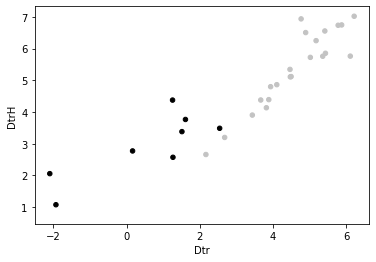

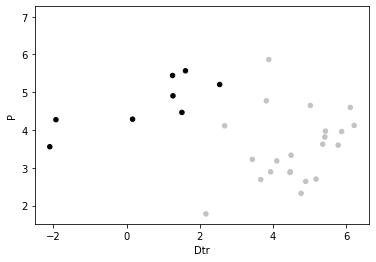

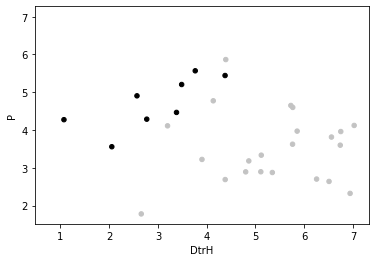

In [20]:
value = 'raw'
for cls1 in ['Dtr', 'DtrH', 'P'] :
    for cls2 in ['Dtr', 'DtrH', 'P']:
        if cls1 < cls2:
            dfr.plot.scatter(x=(value, cls1), y=(value, cls2),
                             color=pd.util.hash_array(dfr['true_class']['Dtr']))
            plt.xlabel(cls1)
            plt.ylabel(cls2)
            plt.show()

KeyError: 'Dtr'

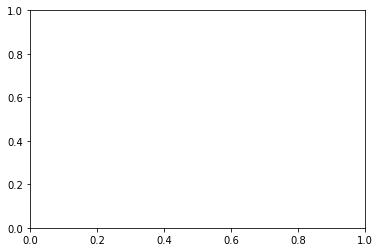

In [12]:
df_res.plot.scatter(x='Dtr', y='P', color=pd.util.hash_array(df_res['true_class']) ); plt.show()
df_res.plot.scatter(x='Dtr', y='DtrH', color=pd.util.hash_array(df_res['true_class']) ); plt.show() 
df_res.plot.scatter(x='P', y='DtrH', color=pd.util.hash_array(df_res['true_class']) ); plt.show() 

In [67]:
df_res

,cls,n1,n2,pval_2smp,pval_bartlett,pval_f,pval_levene,pval_t,pval_tLDA,doc_tested,len,true_class
0,Dtr,7.0,8.0,0.896193,0.998586,0.434164,0.948027,0.279647,0.271533,Dtr|Deut.12,824,Dtr
1,DtrH,19.0,20.0,0.565393,0.538336,0.693224,0.367876,0.354733,0.312754,Dtr|Deut.12,824,Dtr
2,P,22.0,23.0,0.566215,0.404383,0.174723,0.610349,0.002233,0.001654,Dtr|Deut.12,824,Dtr
3,Dtr,7.0,8.0,0.481921,0.805077,0.531136,0.751533,0.149619,0.123025,Dtr|Deut.13,519,Dtr
4,DtrH,19.0,20.0,0.937944,0.842027,0.535372,0.788162,0.419803,0.415621,Dtr|Deut.13,519,Dtr
...,...,...,...,...,...,...,...,...,...,...,...,...
142,DtrH,19.0,20.0,0.216506,0.339120,0.143620,0.712078,0.000127,0.000184,P|Lev.8,866,P
143,P,21.0,22.0,0.882875,0.909075,0.413111,0.961778,0.411597,0.393498,P|Lev.8,866,P
144,Dtr,8.0,9.0,0.552988,0.473816,0.192220,0.954449,0.105361,0.047010,P|Lev.9,503,P
145,DtrH,19.0,20.0,0.530283,0.661812,0.292128,0.860605,0.010586,0.009048,P|Lev.9,503,P


In [37]:
df_res

,Dtr,DtrH,P,doc_tested,len,true_class,predicted_class
0,1.274227,1.036390,6.104557,Dtr|Deut.12,824.0,Dtr,DtrH
1,1.899661,0.867971,2.653439,Dtr|Deut.13,519.0,Dtr,DtrH
2,0.003518,1.122781,3.198606,Dtr|Deut.15,567.0,Dtr,Dtr
3,1.174786,3.150986,2.940416,Dtr|Deut.16,514.0,Dtr,Dtr
4,0.287107,0.272530,4.895184,Dtr|Deut.18,458.0,Dtr,DtrH
5,1.271815,1.983998,4.308268,Dtr|Deut.19,523.0,Dtr,Dtr
6,0.306119,1.242663,3.866526,Dtr|Deut.26,549.0,Dtr,Dtr
7,1.640469,1.773175,4.529676,Dtr|Deut.6,515.0,Dtr,Dtr
8,2.629495,2.010008,6.186513,DtrH|1Kgs.8,1731.0,DtrH,DtrH
9,2.322208,2.435022,2.420678,DtrH|2Kgs.17,509.0,DtrH,Dtr


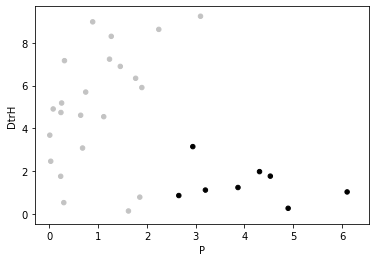